# Pleiades: Workprecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Pleiades">
             Initial value problem: Pleiades</a></li>     
                          
<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>  

</ul>  

- PLEI- a celestial mechanics problem: seven stars in the plane with coordinates $x_i,y_i$ and masses $m_i=i$ ($i=1,\dots,7$)  

\begin{align*}
&x_i^{''}=\sum_{j \ne i} m_j(x_j-x_i)/r_{ij} \\
&y_i^{''}=\sum_{j \ne i} m_j(y_j-y_i)/r_{ij} 
\end{align*}

where

\begin{align*}
r_{ij}=((x_i-x_j)^2+ (y_i-y_j)^2)^{3/2}, \quad i,j=1,\dots,7
\end{align*}

- The initial values are

\begin{align*}
& x_1(0)=3, \quad x_2(0)=3, \quad x_3(0)=-1, \quad x_4(0)=-3, \\
& x_5(0)=2, \quad x_6(0)=-2, \quad x_7(0)=2 \\
& y_1(0)=3, \quad y_2(0)=-3, \quad y_3(0)=2, \quad y_4(0)=0, \\
& y_5(0)=0, \quad y_6(0)=-4, \quad y_7(0)=4, \\
& x'_i(0)=y'_i(0)=0 \ \text{ for all } i \text{ with the exception of} \\
& x'_6(0)=1.75, \quad x'_7(0)=-1.5, \quad y'_4(0)=-1.25, \quad y'_5(0)=1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Solving Ordinary Differential Equations I (Nonstiff Problems), E.Hairer, S.P:Norsett, G.Wanner, (245 page), Springer

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Pleiades

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Pleiades.jl")
include("../ODEProblems/InitialPleiades.jl")

t0=0.0
t1=3.0

u064 =InitialPleiades(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(f,u064,tspan64);

u0128=InitialPleiades(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(f,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

q064=copy(u064[1:14])
v064=copy(u064[15:28])
probdyn64 = DynamicalODEProblem(dotq,dotv,q064,v064,tspan64)
prob2nd64 = SecondOrderODEProblem(f2nd!,v064,q064,tspan64)


q0128=copy(u0128[1:14])
v0128=copy(u0128[15:28])
probdyn128 = DynamicalODEProblem(dotq,dotv,q0128,v0128,tspan128)
prob2nd128 = SecondOrderODEProblem(f2nd!,v0128,q0128,tspan128);

<a href="#top">Back to the top</a>

## Test solution

In [6]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/plei_test_sol.jld2" sol

@load "./Data/plei_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256 =InitialPleiades(BigFloat)
Gm256=BigFloat.([1,2,3,4,5,6,7])

E0=NbodyEnergy(u0256,Gm256)
(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0.-1))

(3.0f0, 5.9543627f-33)

In [7]:
ux=sol.u[end]
solx=ArrayPartition(ux[1:14], ux[15:28])
test_solx = TestSolution(tspan128,[solx])

ux=sol.u[end]
solx2nd=ArrayPartition(ux[15:28],ux[1:14])
test_solx2nd = TestSolution(tspan128,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [8]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Second Order Problem: Vern9, IRKGL16

In [9]:
setups = [
          Dict(:alg=>Vern9()),
          Dict(:alg=>IRKGL16(),:adaptive=>true)
]
solnames = ["Vern9","IRKGL16-adaptive"]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=10,maxiters=10^9, names=solnames);

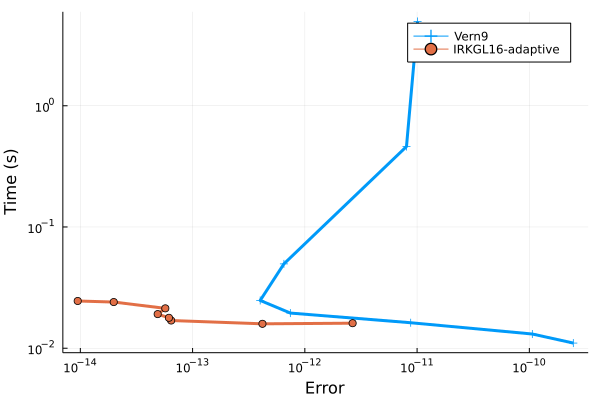

In [10]:
plot(wp2)

### SecondOrderProblem: DPRKN12

In [11]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames);

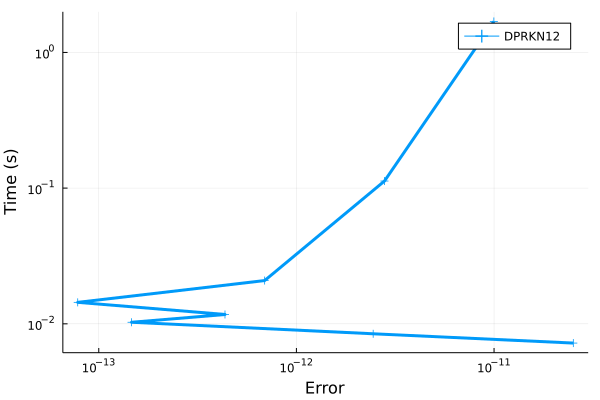

In [12]:
plot(wp3)

### All methods in one Plot

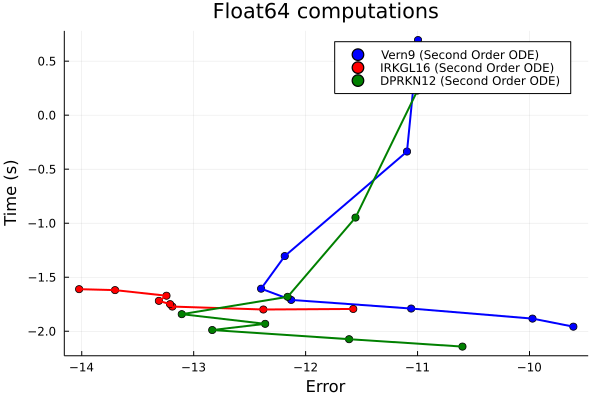

In [13]:
plot(title="Float64 computations",xlabel="Error", ylabel="Time (s)")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9 (Second Order ODE)", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16 (Second Order ODE)", color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12 (Second Order ODE)", color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [14]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Second Order ODE: Vern9, IRKGL16 (mixed-precision=true)

In [15]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(mixed_precision=false),:adaptive=>true) 
           Dict(:alg=>IRKGL16(mixed_precision=true),:adaptive=>true)
           Dict(:alg=>IRKGL16(mixed_precision=true,threading=true),:adaptive=>true)
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/mix", "IRKGL16-adaptive/mix/threads" ]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=10,maxiters=10^9, name=solnames);

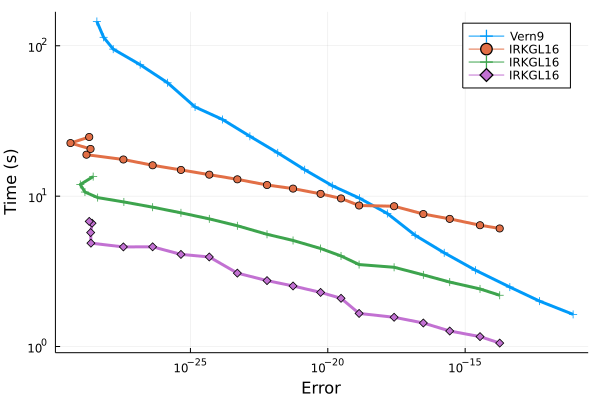

In [16]:
plot(wp11)

### Second Order ODE: Vern9, IRKGL16  (mixed-precision=false)

In [17]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(mixed_precision=false),:adaptive=>true) 
          Dict(:alg=>IRKGL16(mixed_precision=false,threading=true),:adaptive=>true) 
]
solnames=["Vern9", "IRKGL16-adaptive", "IRKGL16-adaptive/thread"]
wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9,names=solnames);

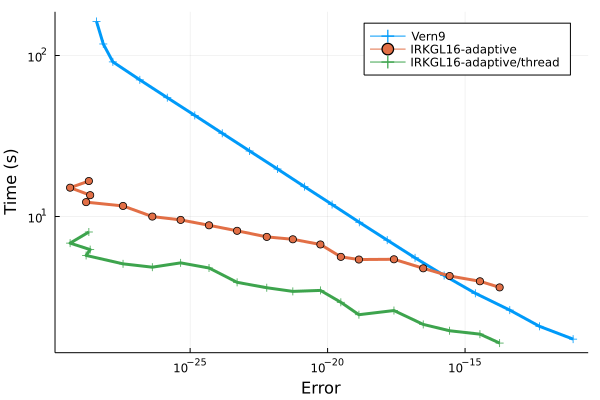

In [18]:
plot(wp12)

### Second Order ODE: DPRKN12

In [19]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9,names=solnames);

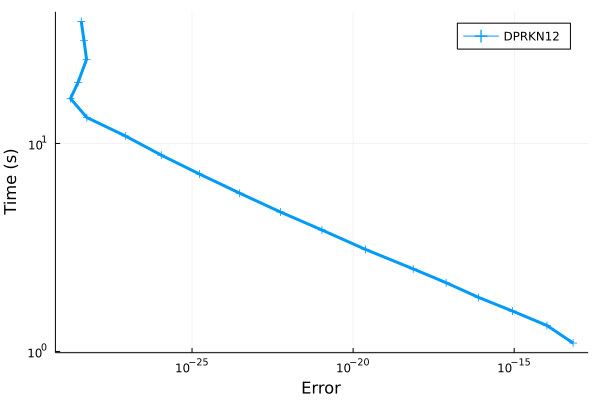

In [20]:
plot(wp13)

### Plot- Vern9:   General Ode vs Second Order ODE

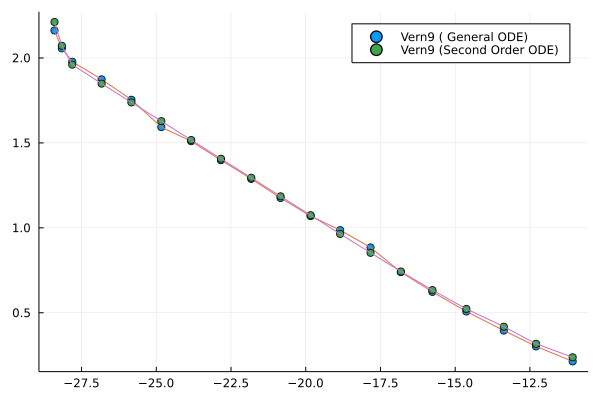

In [21]:
k=1
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 ( General ODE)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=1
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (Second Order ODE)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")

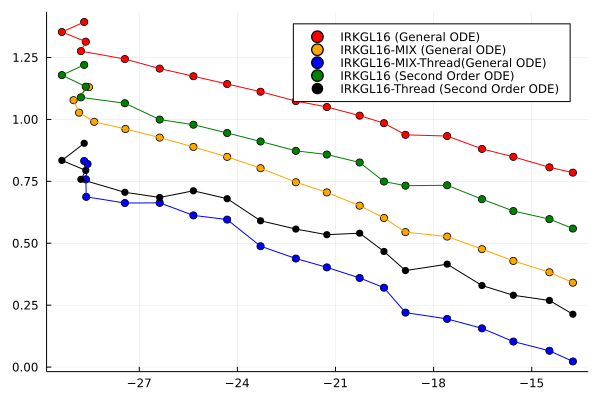

In [22]:
k=2
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16 (General ODE)", color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (General ODE)",  color="orange")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="orange")
#
k=4
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX-Thread(General ODE)",  color="blue")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="blue")
# 
k=2
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (Second Order ODE)",  color="green")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="green")
# 
k=3
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16-Thread (Second Order ODE)",  color="black")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="black")

### Plot for JuliaCon2020

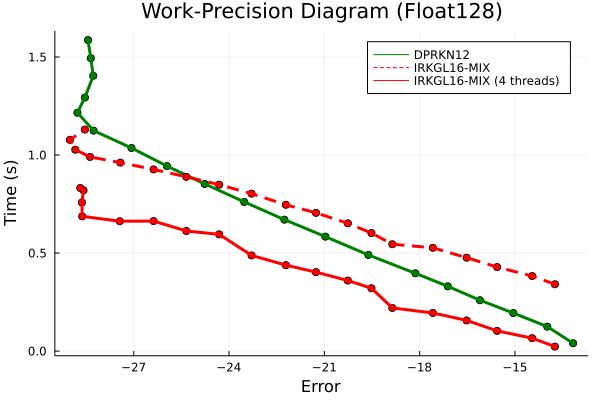

In [23]:
plot(title="Work-Precision Diagram (Float128)", xlabel="Error", ylabel="Time (s)")
#k=1
#plot(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)", color="blue")
#plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="",color="blue")
#
k=1
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="", color="green")
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times),  label="DPRKN12", color="green", lw=3)
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="",  color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="IRKGL16-MIX", color="red", lw=3, linestyle=:dash)
# 
k=4
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="",  color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="IRKGL16-MIX (4 threads)", color="red", lw=3)



<a href="#top">Back to the top</a>

### Save/Load Data

In [27]:
# Float64 experiments
#@save "./Data/output/OutPleiades_wp2.jld2" wp2
#@save "./Data/output/OutPleiades_wp3.jld2" wp3
# Float128 experiments
#@save "./Data/output/OutPleiades_wp11.jld2" wp11
#@save "./Data/output/OutPleiades_wp12.jld2" wp12
#@save "./Data/output/OutPleiades_wp13.jld2" wp13

In [25]:
# Float64 experiments
#@load "./Data/output/OutPleiades_wp2.jld2" wp2
#@load "./Data/output/OutPleiades_wp3.jld2" wp3
# Float128 experiments
#@load "./Data/output/OutPleiades_wp11.jld2" wp11
#@load "./Data/output/OutPleiades_wp12.jld2" wp12
#@load "./Data/output/OutPleiades_wp13.jld2" wp13

1-element Vector{Symbol}:
 :wp13

In [26]:
now()

2022-08-05T22:36:33.618